In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_dir = '/content/drive/MyDrive/PPO_Pong_Project_v2'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/models', exist_ok=True)
os.makedirs(f'{project_dir}/metrics', exist_ok=True)
os.makedirs(f'{project_dir}/visualizations', exist_ok=True)
os.makedirs(f'{project_dir}/logs', exist_ok=True)

Mounted at /content/drive


In [2]:
!pip install -q gymnasium[atari,accept-rom-license] stable-baselines3[extra] ale-py wandb

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 11.0 MB/s eta 0:00:00
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [3]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sp3 (sp3-university-of-arizona) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import numpy as np
import json
import ale_py
import gymnasium as gym
from datetime import datetime
from collections import defaultdict
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecMonitor, VecTransposeImage
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback
import matplotlib.pyplot as plt

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
class WandBMetricsCallback(BaseCallback):
    """
    Enhanced callback that:
    1. Logs episode returns to WandB automatically
    2. Tracks steps to reach target return
    3. Saves periodic metrics to JSON as backup
    """
    def __init__(self, save_path, target_return=18.0, save_freq=50000, verbose=1):
        super().__init__(verbose)
        self.save_path = save_path
        self.target_return = target_return
        self.save_freq = save_freq

        # episode tracking
        self.episode_returns = []
        self.episode_lengths = []
        self.timesteps = []

        # target tracking
        self.target_reached = False
        self.steps_to_target = None
        self.episodes_completed = 0

        self.recent_returns = []
        self.window_size = 50

    def _on_step(self):
        # check for completed episodes in all parallel envs
        infos = self.locals.get('infos', [])

        for info in infos:
            if 'episode' in info:
                ep_return = info['episode']['r']
                ep_length = info['episode']['l']

                self.episode_returns.append(float(ep_return))
                self.episode_lengths.append(int(ep_length))
                self.timesteps.append(int(self.num_timesteps))
                self.episodes_completed += 1

                self.recent_returns.append(ep_return)
                if len(self.recent_returns) > self.window_size:
                    self.recent_returns.pop(0)

                wandb.log({
                    "episode/return": ep_return,
                    "episode/length": ep_length,
                    "episode/return_ma50": np.mean(self.recent_returns),
                    "episode/count": self.episodes_completed,
                    "timestep": self.num_timesteps
                })

                # check target
                if not self.target_reached and ep_return >= self.target_return:
                    self.target_reached = True
                    self.steps_to_target = self.num_timesteps
                    wandb.log({"target_reached_at_step": self.num_timesteps})
                    if self.verbose > 0:
                        print(f"target reached at {self.num_timesteps:,} steps return: {ep_return:.2f}")

        # periodic save to JSON for backup
        if self.num_timesteps % self.save_freq == 0:
            self._save_metrics()

        return True

    def _save_metrics(self):
        metrics = {
            'results': {
                'timesteps_so_far': self.num_timesteps,
                'episodes_completed': self.episodes_completed,
                'target_reached': self.target_reached,
                'steps_to_target': self.steps_to_target,
                'mean_return': float(np.mean(self.episode_returns)) if self.episode_returns else 0.0,
                'std_return': float(np.std(self.episode_returns)) if self.episode_returns else 0.0,
            },
            'episode_data': {
                'returns': self.episode_returns,
                'lengths': self.episode_lengths,
                'timesteps': self.timesteps,
            }
        }

        with open(self.save_path, 'w') as f:
            json.dump(metrics, f, indent=2)

    def _on_training_end(self):
        self._save_metrics()
        print(f"total episodes: {self.episodes_completed}")
        print(f"target reached: {self.target_reached}")
        if self.steps_to_target:
            print(f"steps to target: {self.steps_to_target:,}")

Training Function with WandB + TensorBoard

In [6]:
def train_baseline_ppo(
    seed=42,
    total_timesteps=10_000_000,
    n_envs=8,
    target_return=18.0,
    use_wandb=True,
    experiment_name="baseline"
):
    run_name = f"{experiment_name}_seed{seed}"
    print(f"Training: {run_name}")
    print(f"Seed: {seed} | Timesteps: {total_timesteps:,} | Envs: {n_envs}")

    # initialize WandB run
    if use_wandb:
        wandb.init(
            project="csc496-ppo-pong",
            name=run_name,
            config={
                "seed": seed,
                "total_timesteps": total_timesteps,
                "n_envs": n_envs,
                "target_return": target_return,
                "experiment": experiment_name,
                # PPO hyperparams
                "learning_rate": 2.5e-4,
                "n_steps": 128,
                "batch_size": 256,
                "n_epochs": 4,
                "gamma": 0.99,
                "gae_lambda": 0.95,
                "clip_range": 0.1,
                "ent_coef": 0.01,
                "vf_coef": 0.5,
            },
            reinit=True
        )

    # create environment
    def make_env(seed_offset=0):
        def _init():
            env = gym.make("ALE/Pong-v5")
            env = AtariWrapper(env)
            env.reset(seed=seed + seed_offset)
            return env
        return _init

    env = DummyVecEnv([make_env(i) for i in range(n_envs)])
    env = VecFrameStack(env, n_stack=4)
    env = VecTransposeImage(env)
    env = VecMonitor(env)

    # setup TensorBoard logging
    tb_log_dir = f"{project_dir}/logs/{run_name}"

    # create PPO model
    model = PPO(
        policy="CnnPolicy",
        env=env,
        learning_rate=2.5e-4,
        n_steps=128,
        batch_size=256,
        n_epochs=4,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.1,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=1,
        seed=seed,
        tensorboard_log=tb_log_dir,
    )

    # setup callbacks
    metrics_callback = WandBMetricsCallback(
        save_path=f"{project_dir}/metrics/{run_name}_metrics.json",
        target_return=target_return,
        save_freq=100_000,
        verbose=1
    )

    checkpoint_callback = CheckpointCallback(
        save_freq=500_000 // n_envs,
        save_path=f"{project_dir}/models/{run_name}",
        name_prefix="ppo_pong",
    )

    # train
    print("starting training")
    start_time = datetime.now()

    model.learn(
        total_timesteps=total_timesteps,
        callback=[metrics_callback, checkpoint_callback],
        progress_bar=True,
    )

    duration = datetime.now() - start_time

    # save final model
    model_path = f"{project_dir}/models/{run_name}/final_model"
    model.save(model_path)

    # log final stats to WandB
    if use_wandb:
        wandb.log({
            "training_time_hours": duration.total_seconds() / 3600,
            "final_episodes": metrics_callback.episodes_completed,
            "final_mean_return": np.mean(metrics_callback.episode_returns) if metrics_callback.episode_returns else 0,
        })

    print(f"training complete duration: {duration}")
    print(f"Model saved to: {model_path}")

    env.close()

    if use_wandb:
        wandb.finish()

    return model, model_path, metrics_callback

Evaluation Function

In [7]:
def evaluate_model_full(model_path, n_episodes=20, seed=999):
    """
    evaluation that collects:
    - Episode returns
    - Value function estimates (for heatmap)
    - Policy entropy (for heatmap)
    - Action distribution
    """

    # create eval environment
    def make_eval_env():
        def _init():
            env = gym.make("ALE/Pong-v5")
            env = AtariWrapper(env)
            env.reset(seed=seed)
            return env
        return _init

    eval_env = DummyVecEnv([make_eval_env()])
    eval_env = VecFrameStack(eval_env, n_stack=4)
    eval_env = VecTransposeImage(eval_env)

    model = PPO.load(model_path)

    # data collection
    eval_returns = []
    eval_lengths = []
    value_grid = defaultdict(list)
    entropy_grid = defaultdict(list)
    action_counts = defaultdict(int)

    for ep in range(n_episodes):
        obs = eval_env.reset()
        done = False
        ep_return = 0
        step_count = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            action_int = int(action[0])

            # get value and entropy from policy
            obs_tensor = torch.FloatTensor(obs).to(model.device)

            with torch.no_grad():
                features = model.policy.extract_features(obs_tensor)
                if hasattr(model.policy, 'pi_features_extractor'):
                    # separate feature extractors
                    latent_pi = model.policy.mlp_extractor.forward_actor(features)
                    latent_vf = model.policy.mlp_extractor.forward_critic(features)
                else:
                    # shared feature extractor
                    latent_pi, latent_vf = model.policy.mlp_extractor(features)

                value = model.policy.value_net(latent_vf).cpu().numpy()[0, 0]
                logits = model.policy.action_net(latent_pi)
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                entropy = -np.sum(probs * np.log(probs + 1e-8))

            # bin by step position
            x_bin = step_count % 10
            y_bin = (step_count // 10) % 10
            value_grid[(x_bin, y_bin)].append(value)
            entropy_grid[(x_bin, y_bin)].append(entropy)

            # track action
            action_counts[action_int] += 1

            # step
            obs, reward, done, info = eval_env.step(action)
            ep_return += reward[0]
            step_count += 1

        eval_returns.append(ep_return)
        eval_lengths.append(step_count)
        print(f"episode {ep+1:2d}/{n_episodes}: Return = {ep_return:6.1f} | Steps = {step_count}")

    eval_env.close()

    results = {
        'returns': eval_returns,
        'lengths': eval_lengths,
        'mean_return': np.mean(eval_returns),
        'std_return': np.std(eval_returns),
        'median_return': np.median(eval_returns),
        'min_return': np.min(eval_returns),
        'max_return': np.max(eval_returns),
        'value_grid': dict(value_grid),
        'entropy_grid': dict(entropy_grid),
        'action_counts': dict(action_counts),
    }

    print(f"Evaluation Results ({n_episodes} episodes):")
    print(f"Mean return: {results['mean_return']:.2f} ± {results['std_return']:.2f}")
    print(f"Median return: {results['median_return']:.2f}")
    print(f"Range: [{results['min_return']:.0f}, {results['max_return']:.0f}]")

    return results

Visualization Function

In [8]:
def plot_evaluation_results(eval_results, seed, experiment_name="baseline"):
    """
    1. Return distribution histogram
    2. Value function heatmap
    3. Policy entropy heatmap
    4. Action distribution
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # return distribution
    ax = axes[0, 0]
    ax.hist(eval_results['returns'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(eval_results['mean_return'], color='r', linestyle='--', linewidth=2, label='Mean')
    ax.set_xlabel('Return', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Evaluation Return Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # value function heatmap
    ax = axes[0, 1]
    value_matrix = np.zeros((10, 10))
    for key, vals in eval_results['value_grid'].items():
        if isinstance(key, str):
            x, y = eval(key)  # Handle string keys from JSON
        else:
            x, y = key
        if 0 <= x < 10 and 0 <= y < 10:
            value_matrix[y, x] = np.mean(vals)
    im = ax.imshow(value_matrix, cmap='RdYlGn', aspect='auto')
    ax.set_title('Value Function Heatmap', fontsize=12, fontweight='bold')
    ax.set_xlabel('Step Bin (x)', fontsize=11)
    ax.set_ylabel('Step Bin (y)', fontsize=11)
    plt.colorbar(im, ax=ax, label='Mean V(s)')

    # policy entropy heatmap
    ax = axes[1, 0]
    entropy_matrix = np.zeros((10, 10))
    for key, ents in eval_results['entropy_grid'].items():
        if isinstance(key, str):
            x, y = eval(key)
        else:
            x, y = key
        if 0 <= x < 10 and 0 <= y < 10:
            entropy_matrix[y, x] = np.mean(ents)
    im = ax.imshow(entropy_matrix, cmap='viridis', aspect='auto')
    ax.set_title('Policy Entropy Heatmap', fontsize=12, fontweight='bold')
    ax.set_xlabel('Step Bin (x)', fontsize=11)
    ax.set_ylabel('Step Bin (y)', fontsize=11)
    plt.colorbar(im, ax=ax, label='Mean Entropy')

    # action distribution
    ax = axes[1, 1]
    action_names = ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    actions = sorted(eval_results['action_counts'].keys())
    counts = [eval_results['action_counts'][a] for a in actions]
    labels = [action_names[int(a)] if int(a) < len(action_names) else f'A{a}' for a in actions]
    bars = ax.bar(labels, counts, color='coral', edgecolor='black')
    ax.set_title('Action Distribution', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11)
    ax.set_xlabel('Action', fontsize=11)
    plt.xticks(rotation=45)
    ax.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    save_path = f"{project_dir}/visualizations/{experiment_name}_eval_seed{seed}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()


def plot_learning_curve(metrics_path, seed, experiment_name="baseline"):
    """
    Plot learning curve from saved metrics JSON.
    """
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)

    returns = metrics['episode_data']['returns']
    timesteps = metrics['episode_data']['timesteps']

    fig, ax = plt.subplots(figsize=(14, 6))

    # scatter plot of episode returns
    ax.scatter(timesteps, returns, alpha=0.3, s=10, label='Episode returns', color='steelblue')

    # moving average
    window = min(50, len(returns) // 2) if len(returns) > 1 else 1
    if len(returns) >= window and window > 0:
        moving_avg = np.convolve(returns, np.ones(window)/window, mode='valid')
        moving_timesteps = timesteps[window-1:]
        ax.plot(moving_timesteps, moving_avg, 'r-', linewidth=2, label=f'{window}-episode MA')

    ax.axhline(y=18, color='g', linestyle='--', linewidth=2, label='Target (18)')
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

    ax.set_xlabel('Environment Steps', fontsize=12)
    ax.set_ylabel('Episode Return', fontsize=12)
    ax.set_title(f'Learning Curve - {experiment_name.upper()} PPO (Seed {seed})', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)
    ax.set_ylim(-22, 22)

    plt.tight_layout()
    save_path = f"{project_dir}/visualizations/{experiment_name}_learning_curve_seed{seed}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()


def plot_multi_seed_learning_curves(seeds, experiment_name="baseline"):
    """
    Plot learning curves from all seeds on one figure.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(seeds)))

    for i, seed in enumerate(seeds):
        metrics_file = f"{project_dir}/metrics/{experiment_name}_seed{seed}_metrics.json"
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                data = json.load(f)

            timesteps = data['episode_data']['timesteps']
            returns = data['episode_data']['returns']

            ax.scatter(timesteps, returns, alpha=0.1, s=1, color=colors[i])

            # Moving average
            if len(returns) >= 50:
                window = 50
                ma = np.convolve(returns, np.ones(window)/window, mode='valid')
                ma_timesteps = timesteps[window-1:]
                ax.plot(ma_timesteps, ma, label=f'Seed {seed} (MA50)', color=colors[i], linewidth=2)

    ax.axhline(y=18, color='green', linestyle='--', label='Target (18)', linewidth=2)
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

    ax.set_xlabel('Environment Steps', fontsize=12)
    ax.set_ylabel('Episode Return', fontsize=12)
    ax.set_title(f'Learning Curves - {experiment_name.upper()} PPO (All Seeds)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-22, 22)

    plt.tight_layout()
    save_path = f"{project_dir}/visualizations/{experiment_name}_learning_curves_all.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()

Training configs

In [9]:
SEEDS = [42, 43, 44]
TOTAL_TIMESTEPS = 3_000_000
N_ENVS = 8
TARGET_RETURN = 18.0

Train and eval seed 42

In [12]:
seed = 42
model_42, path_42, metrics_42 = train_baseline_ppo(
    seed=seed,
    total_timesteps=TOTAL_TIMESTEPS,
    n_envs=N_ENVS,
    target_return=TARGET_RETURN,
    experiment_name="baseline"
)

Training: baseline_seed42
Seed: 42 | Timesteps: 3,000,000 | Envs: 8


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


Using cuda device


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


starting training
Logging to /content/drive/MyDrive/PPO_Pong_Project_v2/logs/baseline_seed42/PPO_1


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.198        |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 916          |
|    ep_rew_mean          | -8.7         |
| time/                   |              |
|    fps                  | 289          |
|    iterations           | 2692         |
|    time_elapsed         | 9517         |
|    total_timesteps      | 2756608      |
| train/                  |              |
|    approx_kl            | 0.0070612277 |
|    clip_fraction        | 0.161        |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.954       |
|    explained_variance   | 0.662        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0351       |
|    n_updates            | 10764        |
|    policy_gradient_loss | -0.0097      |
|    value_loss           | 0.159        |
---

total episodes: 5684

target reached: False

training complete duration: 2:52:42.762643
Model saved to: /content/drive/MyDrive/PPO_Pong_Project_v2/models/baseline_seed42/final_model


episode/count,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████
episode/length,▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▃▂▃▃▃▃▃▃▄▃▃▄▄▅▆▆▄▅█▆▇▅▅
episode/return,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▂▁▁▁▄▆▄▃▃▇▇▃▆▄█▆▃▅▅
episode/return_ma50,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇█▇█▇
final_episodes,▁
final_mean_return,▁
timestep,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇█
training_time_hours,▁
episode/count,5684
episode/length,955
episode/return,-9


episode  1/20: Return =   -7.0 | Steps = 1096
episode  2/20: Return =    2.0 | Steps = 1203
episode  3/20: Return =   -1.0 | Steps = 1222
episode  4/20: Return =   -2.0 | Steps = 1207
episode  5/20: Return =   -4.0 | Steps = 995
episode  6/20: Return =    1.0 | Steps = 1028
episode  7/20: Return =   -7.0 | Steps = 940
episode  8/20: Return =    1.0 | Steps = 1224
episode  9/20: Return =    2.0 | Steps = 1079
episode 10/20: Return =   -9.0 | Steps = 1025
episode 11/20: Return =   -6.0 | Steps = 941
episode 12/20: Return =  -11.0 | Steps = 784
episode 13/20: Return =   -8.0 | Steps = 868
episode 14/20: Return =  -10.0 | Steps = 856
episode 15/20: Return =  -15.0 | Steps = 867
episode 16/20: Return =    1.0 | Steps = 1278
episode 17/20: Return =   -3.0 | Steps = 1060
episode 18/20: Return =   -5.0 | Steps = 1274
episode 19/20: Return =    3.0 | Steps = 1386
episode 20/20: Return =  -10.0 | Steps = 1055
Evaluation Results (20 episodes):
Mean return: -4.40 ± 5.06
Median return: -4.50
Range:

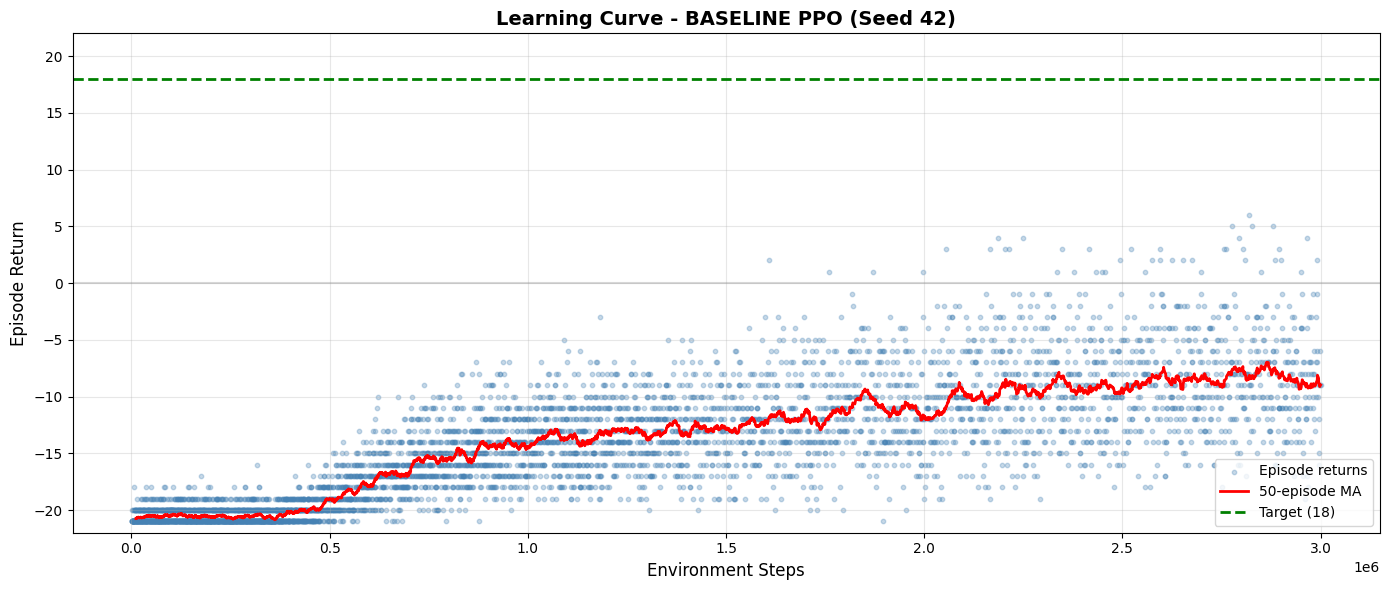

Saved: /content/drive/MyDrive/PPO_Pong_Project_v2/visualizations/baseline_eval_seed42.png


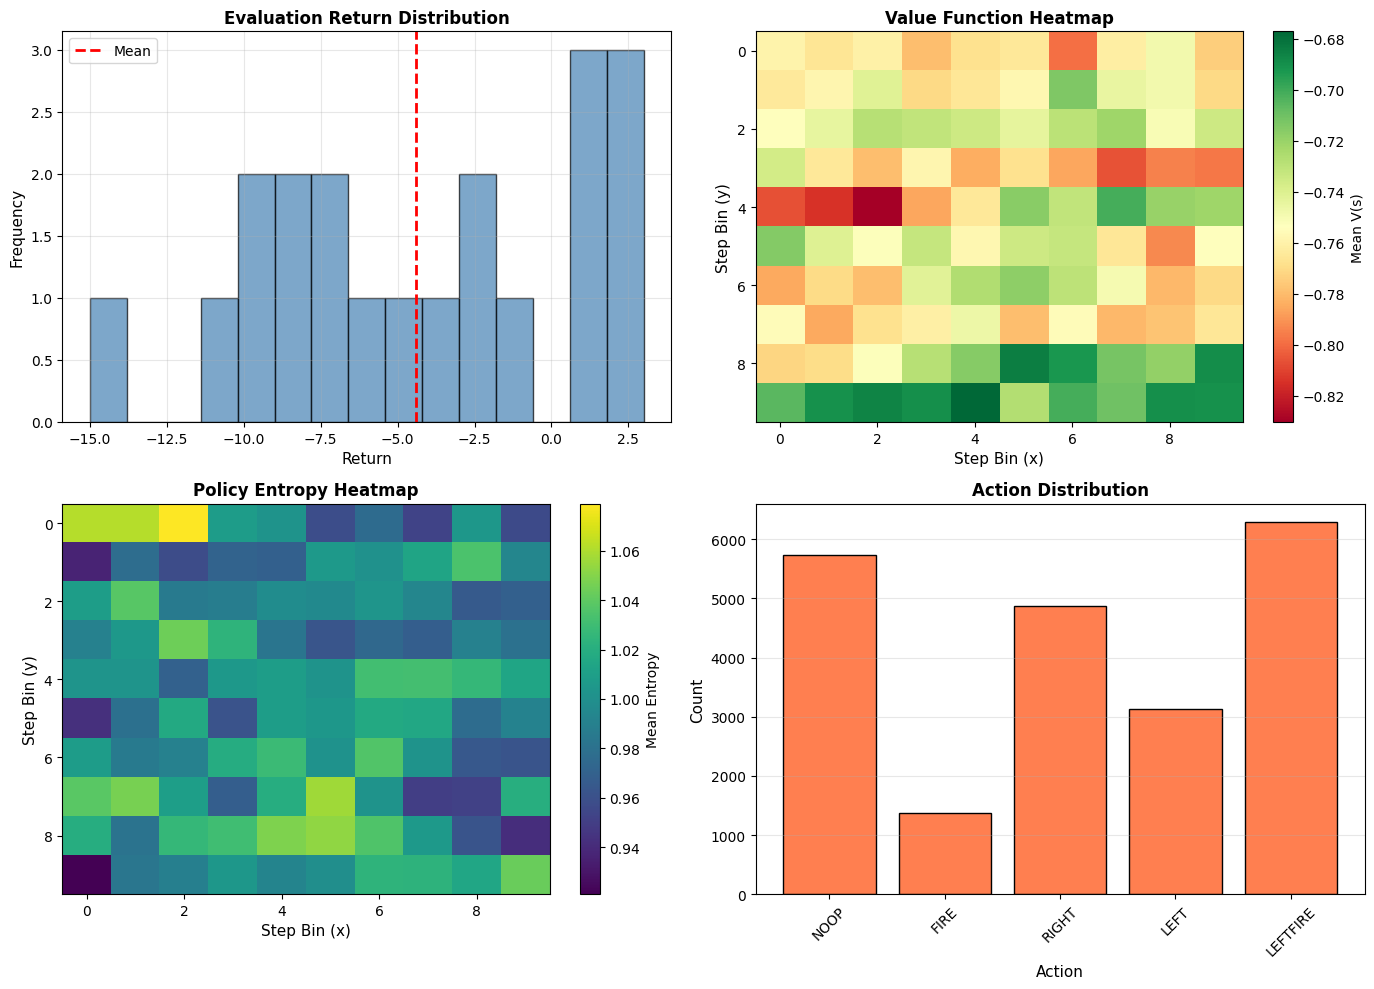

In [15]:
eval_42 = evaluate_model_full(path_42, n_episodes=20)
plot_learning_curve(f"{project_dir}/metrics/baseline_seed42_metrics.json", 42, "baseline")
plot_evaluation_results(eval_42, 42, "baseline")

Train and eval seed 43

In [ ]:
seed = 43
model_43, path_43, metrics_43 = train_baseline_ppo(
    seed=seed,
    total_timesteps=TOTAL_TIMESTEPS,
    n_envs=N_ENVS,
    target_return=TARGET_RETURN,
    experiment_name="baseline"
)

from google.colab import runtime
runtime.unassign()

Training: baseline_seed43
Seed: 43 | Timesteps: 3,000,000 | Envs: 8


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


Using cuda device


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


starting training
Logging to /content/drive/MyDrive/PPO_Pong_Project_v2/logs/baseline_seed43/PPO_1


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.198       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.05e+03     |
|    ep_rew_mean          | -11.3        |
| time/                   |              |
|    fps                  | 286          |
|    iterations           | 2693         |
|    time_elapsed         | 9611         |
|    total_timesteps      | 2757632      |
| train/                  |              |
|    approx_kl            | 0.0076712165 |
|    clip_fraction        | 0.176        |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.831       |
|    explained_variance   | 0.527        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0362       |
|    n_updates            | 10768        |
|    policy_gradient_loss | -0.00953     |
|    value_loss           | 0.144        |
-----

total episodes: 5011

target reached: False

training complete duration: 2:54:13.496350
Model saved to: /content/drive/MyDrive/PPO_Pong_Project_v2/models/baseline_seed43/final_model


episode/count,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
episode/length,▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▂▂▂▁▂▃▃▄▃▄▅▅▅▆▅▇▇▅▇▆█▅▇█▆
episode/return,▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂▂▃▂▃▅▂▄▅▅▃▃▂█▅▄▄▃
episode/return_ma50,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▅▄▅▆▆▅▆▆▇▆▆▇▇█▇▇
final_episodes,▁
final_mean_return,▁
timestep,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▇▇███
training_time_hours,▁
episode/count,5011
episode/length,1152
episode/return,-10


episode  1/20: Return =  -13.0 | Steps = 892


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


episode  2/20: Return =  -15.0 | Steps = 1080
episode  3/20: Return =  -12.0 | Steps = 968
episode  4/20: Return =  -12.0 | Steps = 1095
episode  5/20: Return =   -9.0 | Steps = 866
episode  6/20: Return =   -8.0 | Steps = 1195
episode  7/20: Return =  -11.0 | Steps = 945
episode  8/20: Return =  -18.0 | Steps = 765
episode  9/20: Return =   -8.0 | Steps = 1209
episode 10/20: Return =   -6.0 | Steps = 1409
episode 11/20: Return =  -17.0 | Steps = 855
episode 12/20: Return =   -6.0 | Steps = 1052
episode 13/20: Return =  -10.0 | Steps = 1018
episode 14/20: Return =  -12.0 | Steps = 1127
episode 15/20: Return =  -14.0 | Steps = 871
episode 16/20: Return =  -13.0 | Steps = 978
episode 17/20: Return =  -11.0 | Steps = 1150
episode 18/20: Return =   -8.0 | Steps = 1401
episode 19/20: Return =   -1.0 | Steps = 1507
episode 20/20: Return =  -15.0 | Steps = 957
Evaluation Results (20 episodes):
Mean return: -10.95 ± 3.99
Median return: -11.50
Range: [-18, -1]
Saved: /content/drive/MyDrive/PPO_

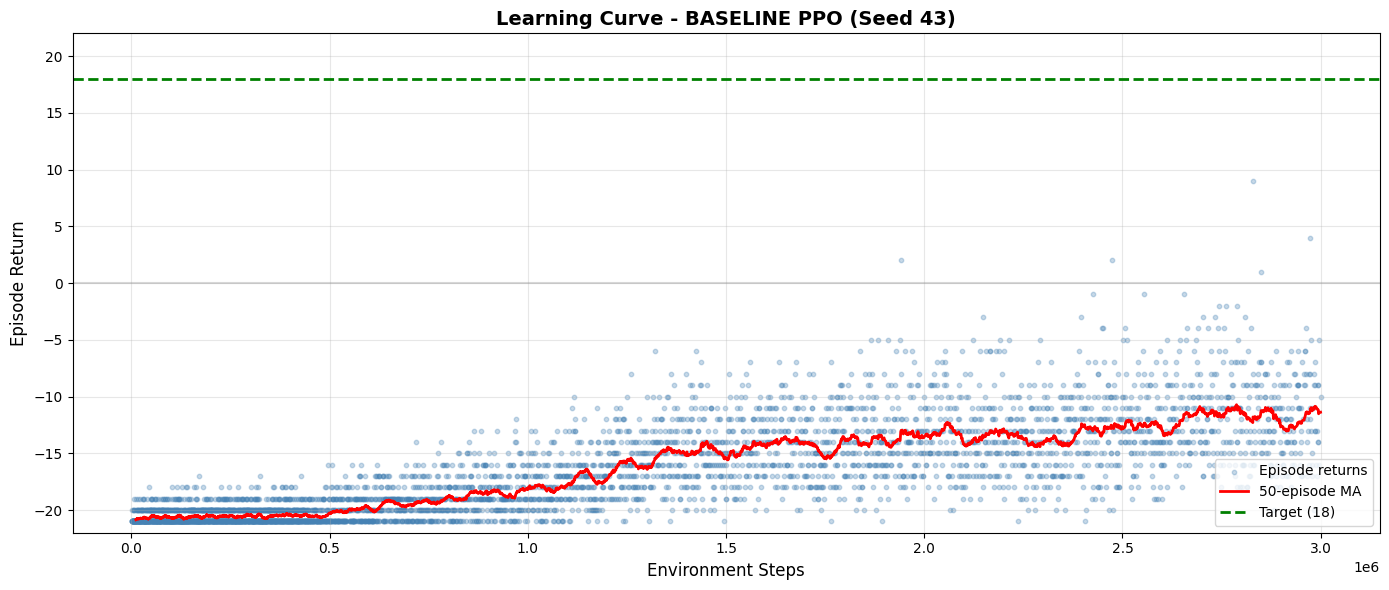

Saved: /content/drive/MyDrive/PPO_Pong_Project_v2/visualizations/baseline_eval_seed43.png


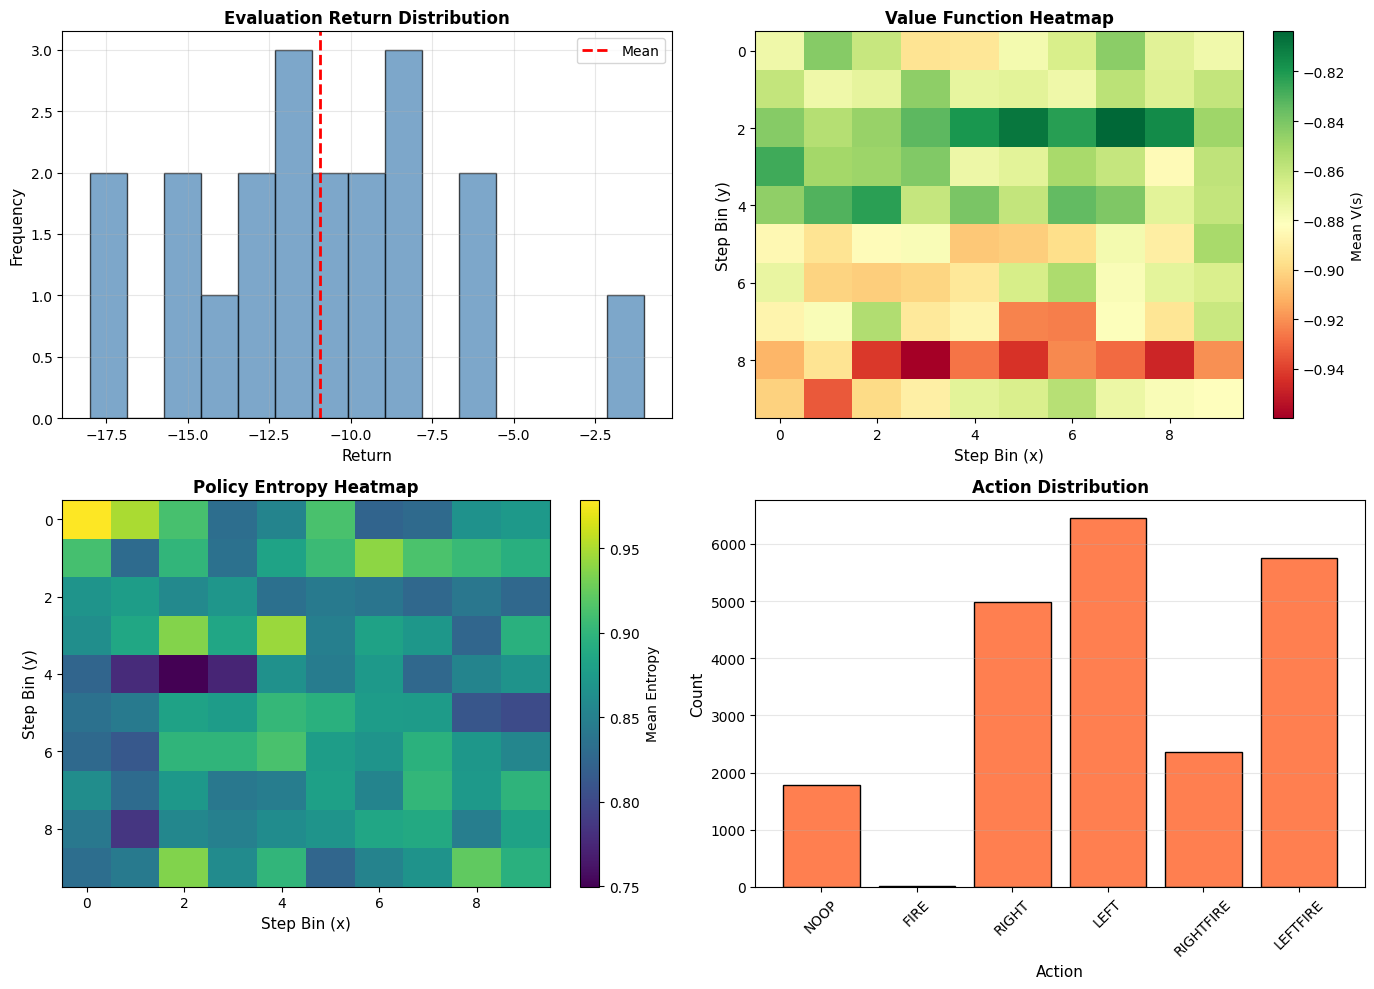

In [11]:
eval_43 = evaluate_model_full(f"{project_dir}/models/baseline_seed43/final_model", n_episodes=20)
plot_learning_curve(f"{project_dir}/metrics/baseline_seed43_metrics.json", 43, "baseline")
plot_evaluation_results(eval_43, 43, "baseline")

Train and eval seed 44

Training: baseline_seed44
Seed: 44 | Timesteps: 3,000,000 | Envs: 8


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


Using cuda device
starting training
Logging to /content/drive/MyDrive/PPO_Pong_Project_v2/logs/baseline_seed44/PPO_1


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.249       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.03e+03     |
|    ep_rew_mean          | -6.27        |
| time/                   |              |
|    fps                  | 266          |
|    iterations           | 2693         |
|    time_elapsed         | 10357        |
|    total_timesteps      | 2757632      |
| train/                  |              |
|    approx_kl            | 0.0081903115 |
|    clip_fraction        | 0.192        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.616        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0513       |
|    n_updates            | 10768        |
|    policy_gradient_loss | -0.00999     |
|    value_loss           | 0.228        |
-----

total episodes: 4750

target reached: False

training complete duration: 3:07:46.174102
Model saved to: /content/drive/MyDrive/PPO_Pong_Project_v2/models/baseline_seed44/final_model


episode/count,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
episode/length,▁▁▁▂▁▁▂▂▂▂▂▃▂▃▂▄▃▃▄▄▅▆▆▆▄▆▅▆▆▇▇█▆█▄▇▆▇▇▇
episode/return,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▂▂▂▃▁▂▂▂▂▃▄▅▃▅▁▄█
episode/return_ma50,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▄▄▄▃▅▅▅▅▅▅▅▆▆▇▆▇▆▇█
final_episodes,▁
final_mean_return,▁
timestep,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇██
training_time_hours,▁
episode/count,4750
episode/length,1097
episode/return,3


episode  1/20: Return =    2.0 | Steps = 1153
episode  2/20: Return =  -14.0 | Steps = 982
episode  3/20: Return =  -11.0 | Steps = 1002
episode  4/20: Return =    2.0 | Steps = 1159
episode  5/20: Return =   -6.0 | Steps = 1129
episode  6/20: Return =  -10.0 | Steps = 1024
episode  7/20: Return =    7.0 | Steps = 1111
episode  8/20: Return =   -6.0 | Steps = 1160
episode  9/20: Return =    2.0 | Steps = 1235
episode 10/20: Return =   -6.0 | Steps = 998
episode 11/20: Return =    7.0 | Steps = 1103
episode 12/20: Return =   14.0 | Steps = 989
episode 13/20: Return =  -15.0 | Steps = 731
episode 14/20: Return =   -8.0 | Steps = 1043
episode 15/20: Return =   -5.0 | Steps = 1132
episode 16/20: Return =   -6.0 | Steps = 1177
episode 17/20: Return =    1.0 | Steps = 1150
episode 18/20: Return =    3.0 | Steps = 1307
episode 19/20: Return =    6.0 | Steps = 978
episode 20/20: Return =    5.0 | Steps = 1018
Evaluation Results (20 episodes):
Mean return: -1.90 ± 7.68
Median return: -2.00
Rang

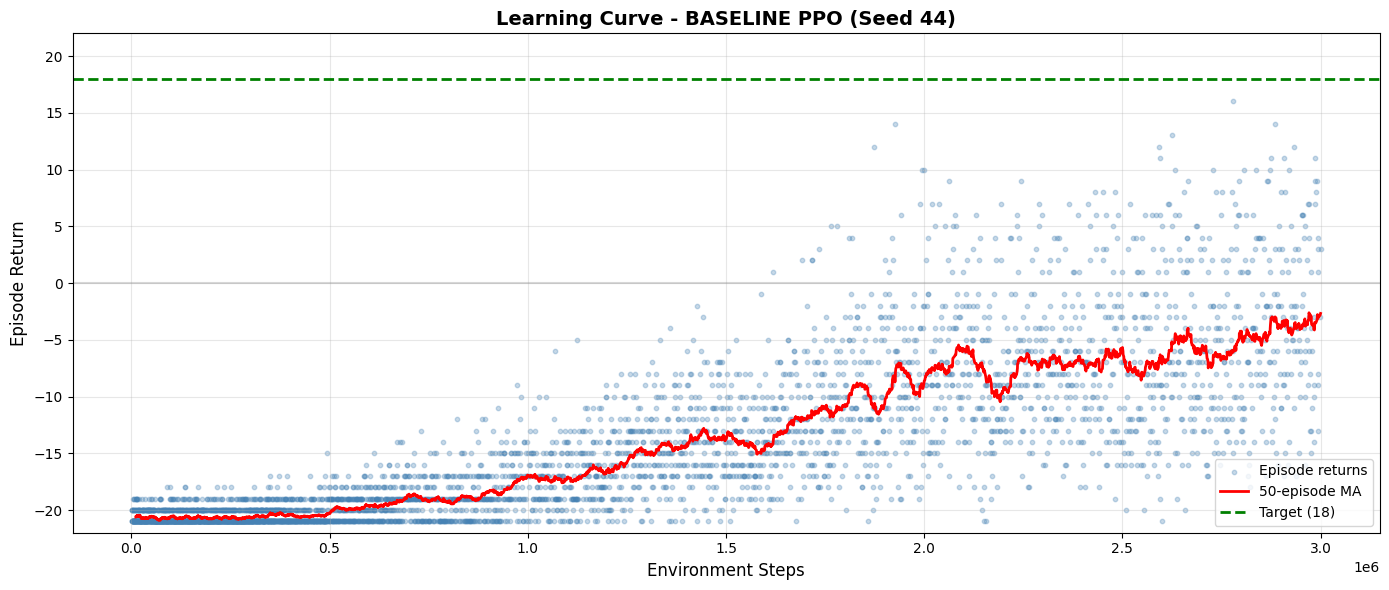

Saved: /content/drive/MyDrive/PPO_Pong_Project_v2/visualizations/baseline_eval_seed44.png


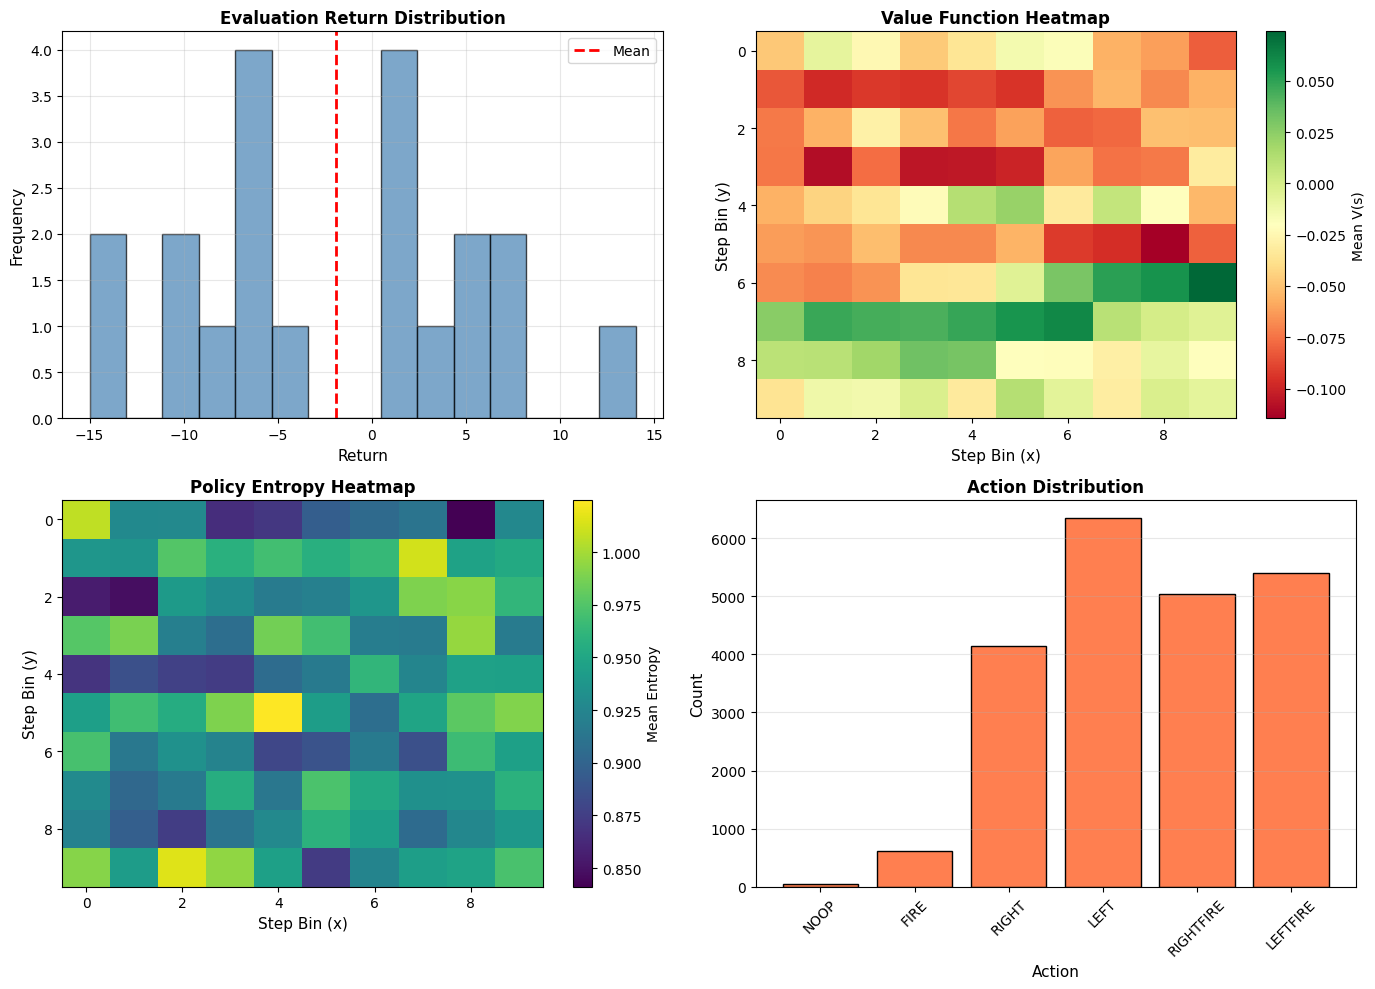

In [12]:
seed = 44
model_44, path_44, metrics_44 = train_baseline_ppo(
    seed=seed,
    total_timesteps=TOTAL_TIMESTEPS,
    n_envs=N_ENVS,
    target_return=TARGET_RETURN,
    experiment_name="baseline"
)

eval_44 = evaluate_model_full(path_44, n_episodes=20)
plot_learning_curve(f"{project_dir}/metrics/baseline_seed44_metrics.json", 44, "baseline")
plot_evaluation_results(eval_44, 44, "baseline")

from google.colab import runtime
runtime.unassign()

Aggregate results and make summary

Saved: /content/drive/MyDrive/PPO_Pong_Project_v2/visualizations/baseline_learning_curves_all.png


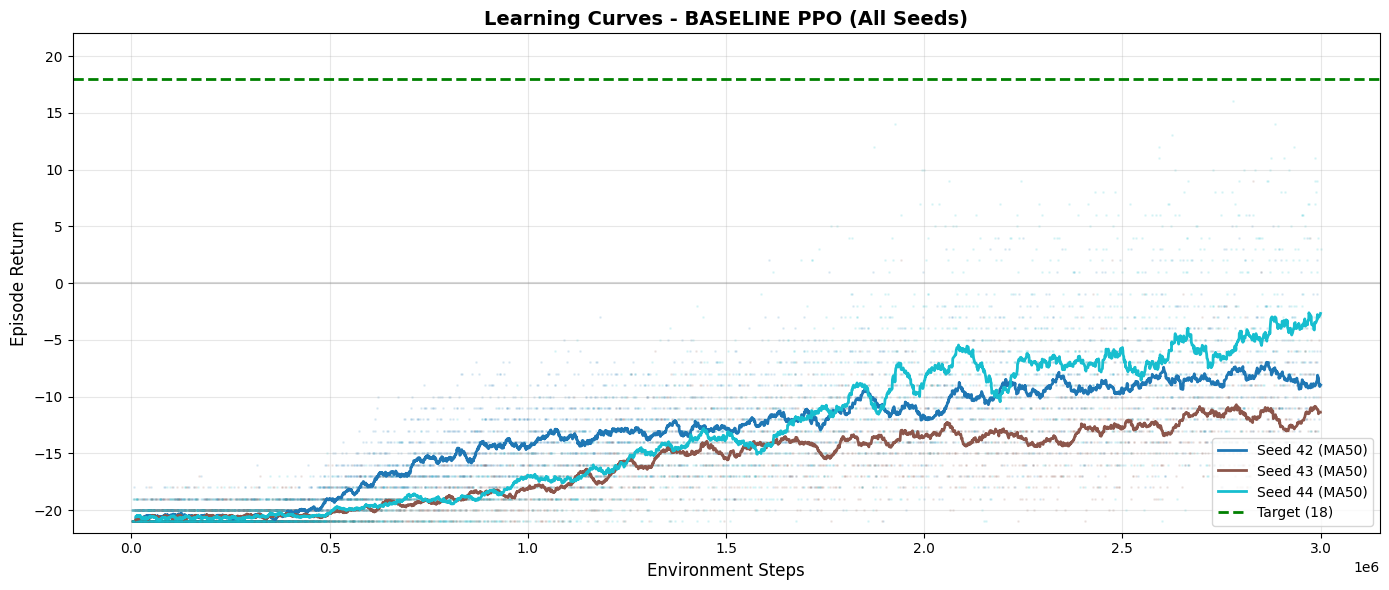

In [10]:
plot_multi_seed_learning_curves(SEEDS, "baseline")

In [11]:
def aggregate_results(seeds, experiment_name="baseline"):
    """
    Aggregate results from multiple seeds and compute statistics.
    """
    all_steps_to_target = []
    all_mean_returns = []

    for seed in seeds:
        metrics_file = f"{project_dir}/metrics/{experiment_name}_seed{seed}_metrics.json"
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                data = json.load(f)

                if data['results']['steps_to_target']:
                    all_steps_to_target.append(data['results']['steps_to_target'])
                all_mean_returns.append(data['results']['mean_return'])

                print(f"Seed {seed}:")
                print(f"Episodes: {data['results']['episodes_completed']}")
                print(f"Mean return: {data['results']['mean_return']:.2f} ± {data['results']['std_return']:.2f}")
                print(f"Target reached: {data['results']['target_reached']}")
                if data['results']['steps_to_target']:
                    print(f"Steps to target: {data['results']['steps_to_target']:,}")

    if all_steps_to_target:
        mean_steps = np.mean(all_steps_to_target)
        std_steps = np.std(all_steps_to_target)
        ci_95 = 1.96 * std_steps / np.sqrt(len(all_steps_to_target))
        print(f"Steps to target: {mean_steps:,.0f} ± {ci_95:,.0f} (95% CI)")
        print(f"Seeds reaching target: {len(all_steps_to_target)}/{len(seeds)}")
    else:
        print("No seeds reached target.")

    print(f"Mean return across seeds: {np.mean(all_mean_returns):.2f} ± {np.std(all_mean_returns):.2f}")

    return {
        'steps_to_target': all_steps_to_target,
        'mean_returns': all_mean_returns,
    }

baseline_results = aggregate_results(SEEDS, "baseline")

Seed 42:
Episodes: 5684
Mean return: -15.36 ± 5.28
Target reached: False
Seed 43:
Episodes: 5011
Mean return: -17.48 ± 4.01
Target reached: False
Seed 44:
Episodes: 4750
Mean return: -15.75 ± 6.89
Target reached: False
No seeds reached target.
Mean return across seeds: -16.20 ± 0.92


In [12]:
def generate_summary_report(seeds, experiment_name="baseline"):
    report = []
    report.append(f"PPO on Atari Pong - {experiment_name.upper()} Results")
    report.append(f"Configuration:")
    report.append(f"Seeds: {seeds}")
    report.append(f"Total timesteps: {TOTAL_TIMESTEPS:,}")
    report.append(f"Parallel envs: {N_ENVS}")
    report.append(f"Target return: {TARGET_RETURN}")

    all_steps = []
    all_returns = []

    for seed in seeds:
        metrics_file = f"{project_dir}/metrics/{experiment_name}_seed{seed}_metrics.json"
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                data = json.load(f)

            report.append(f"Seed {seed}:")
            report.append(f"Episodes: {data['results']['episodes_completed']}")
            report.append(f"Mean return: {data['results']['mean_return']:.2f} ± {data['results']['std_return']:.2f}")
            report.append(f"Target reached: {data['results']['target_reached']}")

            if data['results']['steps_to_target']:
                report.append(f"Steps to target: {data['results']['steps_to_target']:,}")
                all_steps.append(data['results']['steps_to_target'])

            all_returns.append(data['results']['mean_return'])


    if all_steps:
        mean_steps = np.mean(all_steps)
        std_steps = np.std(all_steps)
        ci_95 = 1.96 * std_steps / np.sqrt(len(all_steps))
        report.append(f"Steps to target: {mean_steps:,.0f} ± {ci_95:,.0f} (95% CI)")
        report.append(f"Seeds reaching target: {len(all_steps)}/{len(seeds)}")

    report.append(f"Mean return: {np.mean(all_returns):.2f} ± {np.std(all_returns):.2f}")

    report_text = "\n".join(report)
    print(report_text)

    with open(f"{project_dir}/summary_{experiment_name}.txt", 'w') as f:
        f.write(report_text)
    print(f"\nSaved to: {project_dir}/summary_{experiment_name}.txt")

generate_summary_report(SEEDS, "baseline")

PPO on Atari Pong - BASELINE Results
Configuration:
Seeds: [42, 43, 44]
Total timesteps: 3,000,000
Parallel envs: 8
Target return: 18.0
Seed 42:
Episodes: 5684
Mean return: -15.36 ± 5.28
Target reached: False
Seed 43:
Episodes: 5011
Mean return: -17.48 ± 4.01
Target reached: False
Seed 44:
Episodes: 4750
Mean return: -15.75 ± 6.89
Target reached: False
Mean return: -16.20 ± 0.92

Saved to: /content/drive/MyDrive/PPO_Pong_Project_v2/summary_baseline.txt
